In [6]:
% matplotlib inline
from __future__ import (division, 
                        print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel

# AstroML
from astroML.plotting import hist
from astroML.density_estimation import KNeighborsDensity
try:
    from sklearn.neighbors import KernelDensity
    use_sklearn_KDE = True
except:
    import warnings
    warnings.warn("KDE will be removed in astroML version 0.3.  Please "
                  "upgrade to scikit-learn 0.14+ and use "
                  "sklearn.neighbors.KernelDensity.", DeprecationWarning)
    from astroML.density_estimation import KDE
    use_sklearn_KDE = False
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

# Matplotlib related
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 

# Personal
import hscUtils as hUtil
#import galSBP
import coaddCutoutGalfitSimple as gSimple 

# Cosmology
import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

# Color map 
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap
PUR = Purples_9.mpl_colormap

# Personal tools
from hscUtils import songPlotSetup, removeIsNullCol
from hscUtils import confidence_interval, ma_confidence_interval_1d, confidence_interval_1d

## Constants
# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

# Solar stellar metallicity 
Z_SUN = 0.02

# definitions for the axes
left, width    = 0.12, 0.66
right          = left + width 
bottom, height = 0.14, 0.85
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.21, height]
SBP1 = [0.13, 0.12, 0.865, 0.30]
SBP2 = [0.13, 0.42, 0.865, 0.54]
EC1 = [0.135, 0.066, 0.862, 0.30]
EC2 = [0.135, 0.366, 0.862, 0.30]
EC3 = [0.135, 0.666, 0.862, 0.30]
REC = [0.12, 0.11, 0.87, 0.87]
COG1 = [0.143, 0.10, 0.850, 0.43]
COG2 = [0.143, 0.53, 0.850, 0.43]

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)
EMPTY = (RSMA_COMMON * np.nan)

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"
RED0 = "#f4a582"
RED1 = "#ca0020"
PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'
BROWN0 = '#bf812d'
BROWN1 = '#543005'
GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

# 3-sigma
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

In [2]:
# Location of the data
homeDir = os.getenv('HOME')

sbpDir = os.path.join(homeDir, 'astro4/massive/dr15b/sbp/')
# Location for figures
figDir = os.path.join(sbpDir, 'figure')
# Location for subsamples
sampleDir = os.path.join(sbpDir, 'catalog')
# Location for lensing results
lenDir = os.path.join(homeDir, 'astro4/massive/dr15b/lensing/')

# Read in the lensing results
redbcg_mbin1_lens = Table.read(os.path.join(lenDir, 'redBCG_fsps1_MBin1.txt'), format='ascii')
redbcg_mbin2_lens = Table.read(os.path.join(lenDir, 'redBCG_fsps1_MBin2.txt'), format='ascii')
redbcg_mbin3_lens = Table.read(os.path.join(lenDir, 'redBCG_fsps1_MBin3.txt'), format='ascii')

nonbcg_mbin1_lens = Table.read(os.path.join(lenDir, 'nonBCG_fsps1_MBin1.txt'), format='ascii')
nonbcg_mbin2_lens = Table.read(os.path.join(lenDir, 'nonBCG_fsps1_MBin2.txt'), format='ascii')

redbcg_zbin1_lens = Table.read(os.path.join(lenDir, 'redBCG_fsps1_ZBin1.txt'), format='ascii')
redbcg_zbin2_lens = Table.read(os.path.join(lenDir, 'redBCG_fsps1_ZBin2.txt'), format='ascii')

nonbcg_zbin1_lens = Table.read(os.path.join(lenDir, 'nonBCG_fsps1_ZBin1.txt'), format='ascii')
nonbcg_zbin2_lens = Table.read(os.path.join(lenDir, 'nonBCG_fsps1_ZBin2.txt'), format='ascii')

In [3]:
redMR1, redMS1, redMSe1 = redbcg_mbin1_lens['col1'], redbcg_mbin1_lens['col2'], redbcg_mbin1_lens['col3']
redMR2, redMS2, redMSe2 = redbcg_mbin2_lens['col1'], redbcg_mbin2_lens['col2'], redbcg_mbin2_lens['col3']
redMR3, redMS3, redMSe3 = redbcg_mbin3_lens['col1'], redbcg_mbin3_lens['col2'], redbcg_mbin3_lens['col3']

nonMR1, nonMS1, nonMSe1 = nonbcg_mbin1_lens['col1'], nonbcg_mbin1_lens['col2'], nonbcg_mbin1_lens['col3']
nonMR2, nonMS2, nonMSe2 = nonbcg_mbin2_lens['col1'], nonbcg_mbin2_lens['col2'], nonbcg_mbin2_lens['col3']

redML1, redMU1 = (redMS1 - redMSe1), (redMS1 + redMSe1)
redML2, redMU2 = (redMS2 - redMSe2), (redMS2 + redMSe2)
redML3, redMU3 = (redMS3 - redMSe3), (redMS3 + redMSe3)

nonML1, nonMU1 = (nonMS1 - nonMSe1), (nonMS1 + nonMSe1)
nonML2, nonMU2 = (nonMS2 - nonMSe2), (nonMS2 + nonMSe2)

In [4]:
redZR1, redZS1, redZSe1 = redbcg_zbin1_lens['col1'], redbcg_zbin1_lens['col2'], redbcg_zbin1_lens['col3']
redZR2, redZS2, redZSe2 = redbcg_zbin2_lens['col1'], redbcg_zbin2_lens['col2'], redbcg_zbin2_lens['col3']

nonZR1, nonZS1, nonZSe1 = nonbcg_zbin1_lens['col1'], nonbcg_zbin1_lens['col2'], nonbcg_zbin1_lens['col3']
nonZR2, nonZS2, nonZSe2 = nonbcg_zbin2_lens['col1'], nonbcg_zbin2_lens['col2'], nonbcg_zbin2_lens['col3']

redZL1, redZU1 = (redZS1 - redZSe1), (redZS1 + redZSe1)
redZL2, redZU2 = (redZS2 - redZSe2), (redZS2 + redZSe2)

nonZL1, nonZU1 = (nonZS1 - nonZSe1), (nonZS1 + nonZSe1)
nonZL2, nonZU2 = (nonZS2 - nonZSe2), (nonZS2 + nonZSe2)

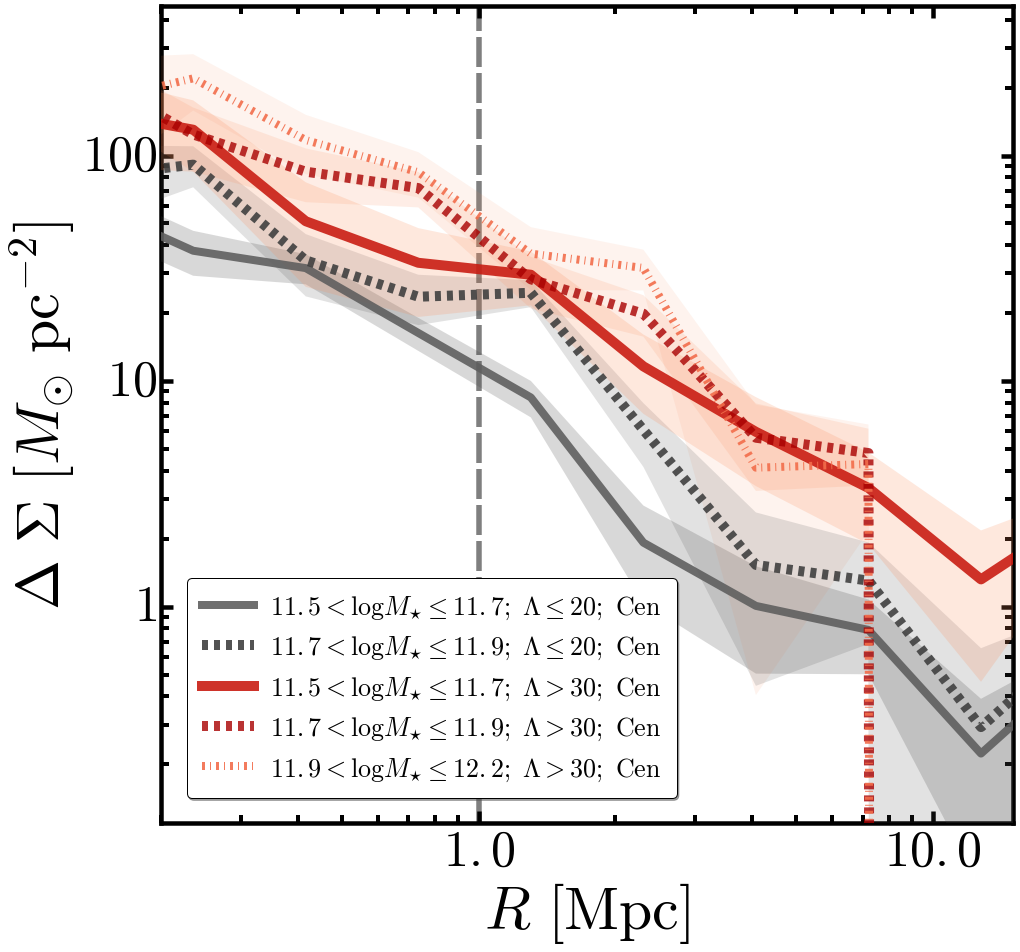

In [7]:
vline1, vline2 = 10.0, 100.0
matchR, highlight1, highlight2 = 100.0, True, False
#-------------------------------------------------------------------------------#
xmin, xmax = 0.2, 14.99 
ymin, ymax =0.11, 459.0 
#xmin, xmax = -1.01, 1.29 
#ymin, ymax = -1.45, 2.69
norm, integrate, normR1 = False, False, 10.0
dmin, dmax = -0.199, 0.399
showLegend = True
#-------------------------------------------------------------------------------#
label1="$11.5 < \log{M_{\star}} \leq 11.7;\ \Lambda > 30;\ \mathrm{Cen}$"
label2="$11.7 < \log{M_{\star}} \leq 11.9;\ \Lambda > 30;\ \mathrm{Cen}$"
label3="$11.9 < \log{M_{\star}} \leq 12.2;\ \Lambda > 30;\ \mathrm{Cen}$"

label4="$11.5 < \log{M_{\star}} \leq 11.7;\ \Lambda \leq 20;\ \mathrm{Cen}$"
label5="$11.7 < \log{M_{\star}} \leq 11.9;\ \Lambda \leq 20;\ \mathrm{Cen}$"

showInfo1=True
showInfo2=True
showLegend=True
rPsfKpc=5.5
kpcArr=[2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
color1a=BLK(0.5)
color1b=BLK(0.7)
cmap1=BLK
color2a=ORG(0.5)
color2b=ORG(0.7)
cmap2=ORG
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%g}$'
ytickFormat2='$\mathbf{%g}$'

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(left=0.15, right=0.995, 
                    bottom=0.13, top=0.94,
                    wspace=0.00, hspace=0.00)
# --------------------------------------------------------------------------------------- #

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, ylabel=50, xlabel=50, 
                    xtickFormat=xtickFormat, 
                    ytickFormat=ytickFormat)
# --------------------------------------------------------------------------------------- #
## Mark the two interesting radius
if highlight1:
    ax1.axvline(1.0, linewidth=5.5, c='k', linestyle='--', 
                zorder=0, alpha=0.5, dashes=(30, 6))
else:
    ax1.axvline(1.0, linewidth=4.0, c='k', linestyle='--', 
                zorder=0, alpha=0.2)
# --------------------------------------------------------------------------------------- #
## Median profiles
ax1.fill_between(nonMR1, nonML1, nonMU1, 
                 facecolor=cmap1(0.80), edgecolor='none', alpha=0.2, 
                 zorder=5, label=None)

ax1.fill_between((nonMR2), (nonML2), (nonMU2), 
                 facecolor=cmap1(0.80), edgecolor='none', alpha=0.15, 
                 zorder=6, label=None)

ax1.fill_between((redMR1), (redML1), (redMU1), 
                 facecolor=cmap2(0.50), edgecolor='none', alpha=0.2, 
                 zorder=6, label=None)

ax1.fill_between((redMR2), (redML2), (redMU2), 
                 facecolor=cmap2(0.50), edgecolor='none', alpha=0.15, 
                 zorder=6, label=None)

ax1.fill_between((redMR3), (redML3), (redMU3), 
                 facecolor=cmap2(0.50), edgecolor='none', alpha=0.1, 
                 zorder=5, label=None)


ax1.plot((nonMR1), (nonMS1), linestyle='-', linewidth=8.0, 
         c=cmap1(0.7), alpha=0.9, zorder=7, label=label4)

ax1.plot((nonMR2), (nonMS2), linestyle='--', linewidth=10.0, 
         c=cmap1(0.8), alpha=0.9, zorder=7, label=label5)


ax1.plot((redMR1), (redMS1), linestyle='-', linewidth=10.0, 
         c=cmap2(0.8), alpha=0.9, zorder=8, label=label1)

ax1.plot((redMR2), (redMS2), linestyle='--', linewidth=10.0, 
         c=cmap2(0.9), alpha=0.8, zorder=8, label=label2)

ax1.plot((redMR3), (redMS3), linestyle='-.', linewidth=8.0, 
         c=cmap2(0.6), alpha=0.9, zorder=8, label=label3)
# --------------------------------------------------------------------------------------- #
## X Lables
ax1.set_xlabel('$R\ [\mathrm{Mpc}]$', size=60)
## Y Lables
ax1.set_ylabel('$\Delta\ {\Sigma}\ [M_{\odot}\ \mathrm{pc}^{-2}]$', size=60)
# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
# --------------------------------------------------------------------------------------- #
ax1.set_xscale("log", nonposx='clip')
ax1.set_yscale("log", nonposy='clip')
ax1 = songPlotSetup(ax1, ylabel=50, xlabel=50, 
                    xtickFormat=xtickFormat, 
                    ytickFormat=ytickFormat)
# --------------------------------------------------------------------------------------- #
## Legend
if showLegend:
    ax1.legend(loc=(0.03, 0.03), shadow=True, fancybox=True, 
               numpoints=1, fontsize=26, scatterpoints=1, 
               markerscale=1.2, borderpad=0.6, handletextpad=0.6)
# --------------------------------------------------------------------------------------- #
#ax1.text(0.39, 0.17, '$\mathrm{Comparisons\ with\ other}$',
#         verticalalignment='bottom', horizontalalignment='center',
#         fontsize=45.0, transform=ax1.transAxes)
#ax1.text(0.39, 0.08, '$\mathrm{Observations\ and\ Simulations}$',
#         verticalalignment='bottom', horizontalalignment='center',
#         fontsize=45.0, transform=ax1.transAxes)
# --------------------------------------------------------------------------------------- #

fig.savefig(os.path.join(figDir, 'compare_lensing_mbin_fsps1.pdf'), dpi=180)

fig.show()

/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log10
/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in log10
/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in log10
/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in log10
/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: invalid value encountered in log10
/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in log10
/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in log10


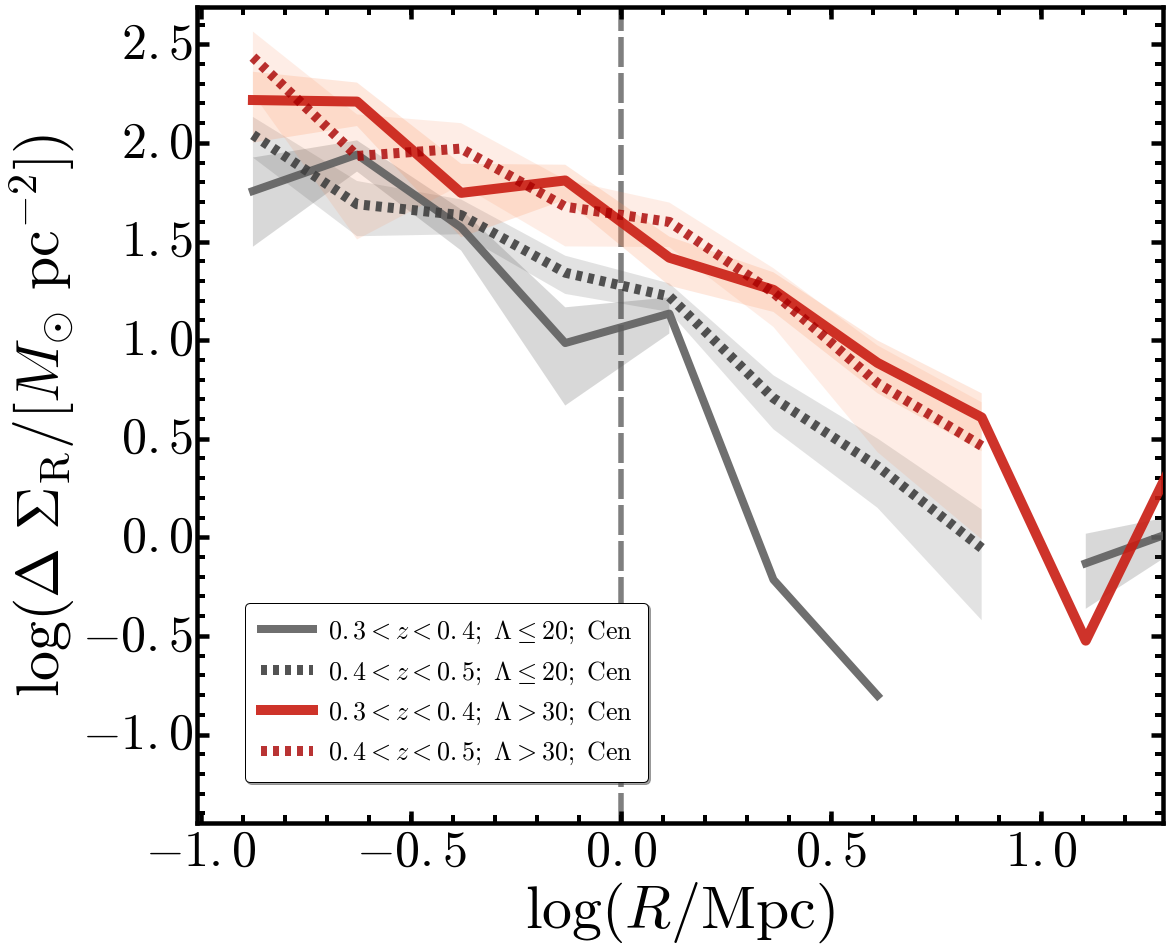

In [8]:
vline1, vline2 = 10.0, 100.0
matchR, highlight1, highlight2 = 100.0, True, False
#-------------------------------------------------------------------------------#
#xmin, xmax = 0.2, 9.9 
#ymin, ymax =0.1, 709.0 
xmin, xmax = -1.01, 1.29 
ymin, ymax = -1.45, 2.69
norm, integrate, normR1 = False, False, 10.0
dmin, dmax = -0.199, 0.399
showLegend = True
#-------------------------------------------------------------------------------#
label1="$0.3 < z < 0.4;\ \Lambda > 30;\ \mathrm{Cen}$"
label2="$0.4 < z < 0.5;\ \Lambda > 30;\ \mathrm{Cen}$"

label4="$0.3 < z < 0.4;\ \Lambda \leq 20;\ \mathrm{Cen}$"
label5="$0.4 < z < 0.5;\ \Lambda \leq 20;\ \mathrm{Cen}$"

showInfo1=True
showInfo2=True
showLegend=True
rPsfKpc=5.5
kpcArr=[2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
color1a=BLK(0.5)
color1b=BLK(0.7)
cmap1=BLK
color2a=ORG(0.5)
color2b=ORG(0.7)
cmap2=ORG
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'
ytickFormat2='$\mathbf{%g}$'

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(15, 14))
fig.subplots_adjust(left=0.10, right=0.995, 
                    bottom=0.13, top=0.94,
                    wspace=0.00, hspace=0.00)
# --------------------------------------------------------------------------------------- #

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, ylabel=50, xlabel=50, 
                    xtickFormat=xtickFormat, 
                    ytickFormat=ytickFormat)
# --------------------------------------------------------------------------------------- #
## Mark the two interesting radius
if highlight1:
    ax1.axvline(np.log10(1.0), linewidth=5.5, c='k', linestyle='--', 
                zorder=0, alpha=0.5, dashes=(30, 6))
else:
    ax1.axvline(np.log10(1.0), linewidth=4.0, c='k', linestyle='--', 
                zorder=0, alpha=0.2)
# --------------------------------------------------------------------------------------- #
## Median profiles
ax1.fill_between(np.log10(nonZR1), np.log10(nonZL1), np.log10(nonZU1), 
                 facecolor=cmap1(0.80), edgecolor='none', alpha=0.2, 
                 zorder=5, label=None)

ax1.fill_between(np.log10(nonZR2), np.log10(nonZL2), np.log10(nonZU2), 
                 facecolor=cmap1(0.80), edgecolor='none', alpha=0.15, 
                 zorder=6, label=None)

ax1.fill_between(np.log10(redZR1), np.log10(redZL1), np.log10(redZU1), 
                 facecolor=cmap2(0.50), edgecolor='none', alpha=0.2, 
                 zorder=6, label=None)

ax1.fill_between(np.log10(redZR2), np.log10(redZL2), np.log10(redZU2), 
                 facecolor=cmap2(0.50), edgecolor='none', alpha=0.15, 
                 zorder=6, label=None)


ax1.plot(np.log10(nonZR1), np.log10(nonZS1), linestyle='-', linewidth=8.0, 
         c=cmap1(0.7), alpha=0.9, zorder=7, label=label4)

ax1.plot(np.log10(nonZR2), np.log10(nonZS2), linestyle='--', linewidth=10.0, 
         c=cmap1(0.8), alpha=0.9, zorder=7, label=label5)


ax1.plot(np.log10(redZR1), np.log10(redZS1), linestyle='-', linewidth=10.0, 
         c=cmap2(0.8), alpha=0.9, zorder=8, label=label1)

ax1.plot(np.log10(redZR2), np.log10(redZS2), linestyle='--', linewidth=10.0, 
         c=cmap2(0.9), alpha=0.8, zorder=8, label=label2)

# --------------------------------------------------------------------------------------- #
## X Lables
ax1.set_xlabel('$\log (R/\mathrm{Mpc})$', size=60)
## Y Lables
ax1.set_ylabel('$\log (\Delta\ {\Sigma}_{\mathrm{R}}/[M_{\odot}\ \mathrm{pc}^{-2}])$', size=60)
# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
# --------------------------------------------------------------------------------------- #
#ax1.set_xscale("log", nonposx='clip')
#ax1.set_yscale("log", nonposy='clip')
# --------------------------------------------------------------------------------------- #
## Legend
if showLegend:
    ax1.legend(loc=(0.05, 0.05), shadow=True, fancybox=True, 
               numpoints=1, fontsize=26, scatterpoints=1, 
               markerscale=1.2, borderpad=0.6, handletextpad=0.6)
# --------------------------------------------------------------------------------------- #
#ax1.text(0.39, 0.17, '$\mathrm{Comparisons\ with\ other}$',
#         verticalalignment='bottom', horizontalalignment='center',
#         fontsize=45.0, transform=ax1.transAxes)
#ax1.text(0.39, 0.08, '$\mathrm{Observations\ and\ Simulations}$',
#         verticalalignment='bottom', horizontalalignment='center',
#         fontsize=45.0, transform=ax1.transAxes)
# --------------------------------------------------------------------------------------- #

fig.savefig(os.path.join(figDir, 'compare_lensing_zbin_fsps1.pdf'), dpi=180)

fig.show()